# Exemples de cartes de corrélation

In [1]:
import numpy as np
import scipy as sp
from numpy import pi
import pandas as pd
from numpy import genfromtxt
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os, copy, re, glob
from pathlib import Path
from math import ceil
from heliumtools.misc.gather_data import export_data_set_to_pickle, apply_ROI, data_filter, get_roi_min_max, get_roi_center, get_roi_size
from heliumtools.correlations import Correlation
from tqdm import tqdm


In [2]:
FOLDER = "/mnt/manip_E/2023/08/08/023"

# Comment récupérer des données ?
## Vérifier les paramètres de fit
Pour fitter le temps d'arrivée du BEC, on utiliser la fonction **fit_BEC_arrival_time** de heliumtools.misc.gather_data.py. Pour vérifier les fits produits par nos paramètres (essentiellement la ROI_for_fit, histogramm_width et width_saturation), on peut appeler la fonction check_BEC_fit qui prend un cycle aléatoire dans le dossier FOLDER et demande à la fonction fit_BEC_arrival_time de fitrer et tracer les données.

    This functions fit BEC arrival times. It generates a dictionary named ans in which we store some properties of the arrival times of our BEC.
    
    Parameters
    ----------
    data : pandas dataframe
    	dataframe pandas avec 3 colonnes X, Y, T les données à fitter
    filename : string,
    	nom du fichier duquel vient les données. Ce nom sera utilisé pour aller chercher les .times correspondant à ce cycle,
    ROI_for_fit : dictionary
    	dictionnaire avec la ROI pouur faire le fit. Cette ROI est appliqué pour tous les axes (X, Y, T et .times)
    histogramm_width : float,
    	en ms, largeur des bins de l'histogramme pour faire le fit selon T et .times
    width_saturation : float,
    	largeur de saturation pendant laquelle il n'y a aucun signal à cause de la saturation du TDC. Les points de l'histogramme entre tmax, temps tel que le signal est maximal et tmax + dt son supprimés et non pris en compte dans le fit,
	show_fit : boolean
		est ce que on veut voir le fit sur une figure (ne pas mettre vrai si on fait plein de fit). Pensez à utiliser la fonction check_BEC_fit si vous voulez vérifier vos fits. 

 ##########  FIT   ##########
p0 : [mean, amplitude, standard_deviation, offset]
Fit in T :
p0 : [307.49499999999773, 71, 0.1, 0]
popt : [3.07596488e+02 1.26836810e+02 9.67073610e-02 6.90034128e-01]
Fit in X :
p0 : [-14.5, 108, 4, 0]
popt : [-13.76236284 101.12702259   4.28744118   1.95888479]
Fit in Y :
p0 : [-0.5, 112, 4, 0]
popt : [ -0.59864092 102.48240707   3.95385518   1.13496712]
Fit in T :
p0 : [307.5049999999977, 136, 0.1, 0]
popt : [3.07599076e+02 2.20584628e+02 9.97696821e-02 1.75188051e+00]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fit in T :
p0 : [307.5249999999977, 133, 0.1, 0]
popt : [3.07609133e+02 1.90114959e+02 9.93127406e-02 1.39167368e+00]
Fit in T :
p0 : [307.5049999999977, 136, 0.1, 0]
popt : [3.07600318e+02 2.32267169e+02 9.49820909e-02 1.01861285e+00]
Fit in T :
p0 : [307.5049999999977, 139, 0.1, 0]
popt : [3.07597623e+02 2.37371207e+02 9.74375047e-02 1.23817490e+00]


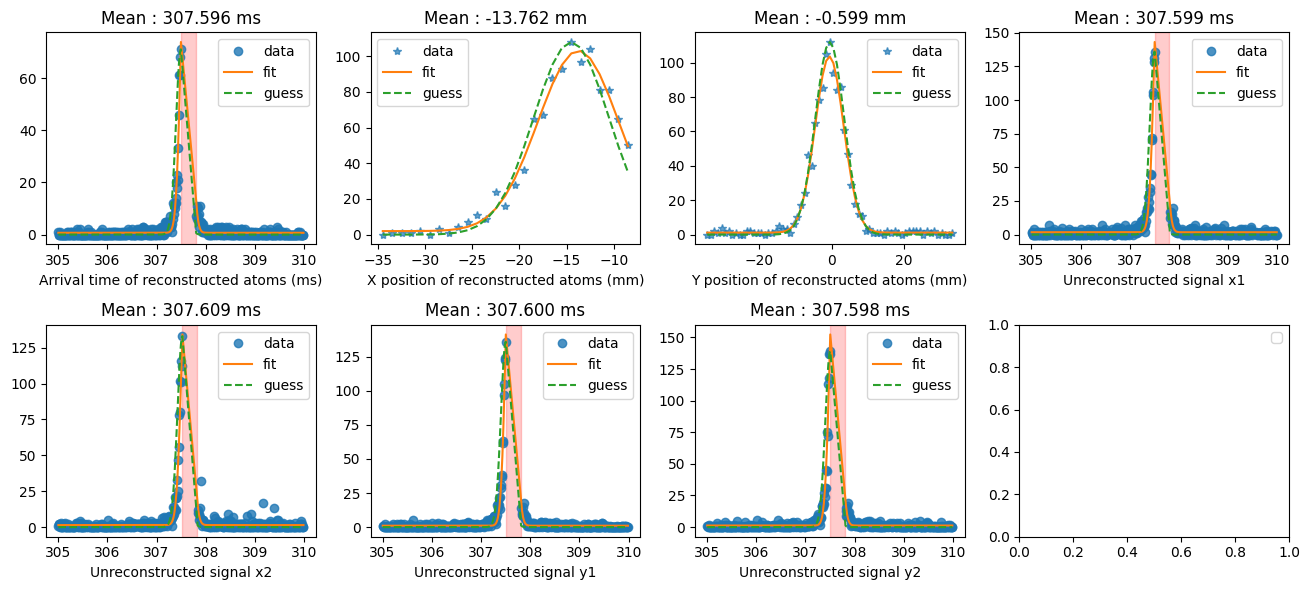

({'Number of Atoms': 2731, 'Number of Atoms in ROIfit': 1095, 'BEC Std Arrival Time': 0.5685953983792142, 'BEC Arrival Time with max': 307.49499999999773, 'BEC Arrival Time': 307.59648793782355, 'BEC fitted Std Arrival Time': 0.09670736095518977, 'BEC Arrival Time with fit': 307.59648793782355, 'BEC Center X': -13.762362835801754, 'BEC Center Y': -0.5986409202048845, 'Mean Arrival Time (fit .times)': 307.6015373178352, 'BEC Std of x1': 0.6829233333130458, 'x1 Arrival Time (maximum)': 307.5049999999977, 'x1 Arrival Time (fit)': 307.5990755110146, 'BEC Std of x2': 0.6455792915117526, 'x2 Arrival Time (maximum)': 307.5249999999977, 'x2 Arrival Time (fit)': 307.60913332904966, 'BEC Std of y1': 0.48329612899640045, 'y1 Arrival Time (maximum)': 307.5049999999977, 'y1 Arrival Time (fit)': 307.60031757552736, 'BEC Std of y2': 0.5455355613039189, 'y2 Arrival Time (maximum)': 307.5049999999977, 'y2 Arrival Time (fit)': 307.59762285574936}, False)


In [3]:
from heliumtools.misc.gather_data import check_BEC_fit
check_BEC_fit(
            FOLDER,
            width_saturation=0.3,
            histogramm_width=0.01,
            ROI_for_fit={
                "T": {"min": 305, "max": 310},
                "X": {"min": -35, "max": -7},
                "Y":{"min":-35, "max":35}
            },
        )

## Concaténer les données d'une séquence

Charger tous les données d'une séquence est assez long : on a donc souvent recours à un unique fichier dans lequel on va concaténer tous les atomes que l'on veut (dans une ROI donnée). On a choisi puor cela d'utiliser des fichiers pickle, qui sont binaires et permettent de stocker efficacement (rapidité de temps de lecture, d'écriture et compacité bonne).

La routine est la suivante, lorsqu'on s'intéresse à une séquence , on va exporter l'ensemble des atomes du dossier à l'aide de la fonction **export_data_set_to_pickle**. Celle-ci va créer un fichier dans le dossier appelé dataset.pkl qui contiendra tous les atomes dans un dataframe pandas. 

Une fois la fonction appelée, les données sont enregistrées et il ne reste plus qu'à charger les atomes (dataset.pkl) et les temps d'arrivée plus paramètres (arrival_times.pkl)

    Exporte le dataset folder en tant que pickle. Cette fonction génère trois fichiers dans le folder. folder/dataset.pkl contient l'ensemble des atomes du dossier dans la ROI. Cette fonction crée également folder/parameters.pkl qui contient l'ensemble des paramètres de la séquence ainsi que folder/arrival_times.pkl qui contient les temps d'arrivée fittés (+ les paramètres) de la séquence. 
    
    Parameters
    ----------
    folder : path like
        chemin vers le dossier contenant tous les .atoms
    ROI : dictionnaire
    	Région d'intérêt : on ne va sélectionner tous les atomes qui sont dans cette ROI. Celle-ci peut être vide et dans ce cas, on garde tous les atomes (et pas aucun). Exemple : {"T": {"min": 300, "max": 350}}. Le format de ce dictionnaire doit matcher le format officiel d'une ROI (voir la fonction apply_ROI pour plus de détails). 
    ROD : dictionnaire
    	Région de désintérêt : on exclue tous les atomes qui sont dans cette région. ATTENTION : cette fonction agit axe par axe pour l'instant malheureusement. 
    find_arrival_times : boolean
    	si True, on fit le temps d'arrivée du BEC. Si False, on ne le fait pas. 
    n_max_cycles : int
    	nombre maximal de cycle qu'on veut sélectionner. Pas souvent utile.
    histogramm_width : float,
    	en ms, largeur des bins de l'histogramme pour faire le fit selon T et .times
    width_saturation : float,
    	largeur de saturation pendant laquelle il n'y a aucun signal à cause de la saturation du TDC. Les points de l'histogramme entre tmax, temps tel que le signal est maximal et tmax + dt son supprimés et non pris en compte dans le fit,
    supplementary_rois : list of ROIs
    	ROIS supplémentaires dans lesquelles on veut compter les atomes (pour appliquer des filtres durant l'analyse d'une séquence par exemple). Les données issus de ces ROIs seront ajoutées au dataf bec arrival_times. 

In [4]:
from heliumtools.misc.gather_data import export_data_set_to_pickle
#export_data_set_to_pickle(
#    FOLDER, 
#    ROI =  {"T": {"min": 310, "max": 325}, "X":[-30,0], "Y":[-15,15]}, 
#    ROD = {},
#    find_arrival_times=True, 
#    histogramm_width=histogramm_width,
#    width_saturation=0.1,
#    ROI_for_fit={"T": {"min": 305, "max": 310},"X": {"min": -35, "max": -7},"Y":{"min":-35, "max":35}}
atoms = pd.read_pickle(os.path.join(FOLDER,"dataset.pkl"))
bec_arrival_times = pd.read_pickle(os.path.join(FOLDER,"arrival_times.pkl"))


## Un petit mot sur les ROIs
Dans tous les codes, on utilise souvent la fonction **apply_ROI** pour faire des sélections. C'est le cas par exemple pour faire du tri dans les données ou de façon implicite lorsqu'on met des atomes dans des boîtes dans les programmes de corrélation. 

Parfois, il est utile de définir une roi par ses valeurs min et max, mais parfois, on préfère utiliser une position et une taille. Les ROIs ont ainsi la possibilité d'avoir différents formats, ainsi les ROIs suivantes sont équivalentes :

    ROI = {"T":[280, 320]}
    ROI = {"T":{"min":280, "max":320}}
    ROI = {"T":{"position":300, "size":40}}
    
On notera enfin l'existence des fonctions suivantes :
* **get_roi_center(roi, axis)** qui renvoit le centre de la roi selon l'axe axis,
* **get_roi_size(roi, axis)** qui renvoie la taille de la ROI selon l'axe axis,
* **get_roi_min_max(roi, axis)** qui renvoie le min et le max de la roi selon l'axe axis.

C'est d'ailleurs dans cette dernière fonction que sont codées tous les formats possibles de ROI.

Accompagnant ces fonction, il y a la fonction **data_filter** qui permet de filtrer des atomes selon des paramètres de séquence. Celle-ci prend en argument un dataframe d'atomes (donc avec une colonne "Cycle", un dataframe avec des paramètres (bec_arrivla_times typiquement) par "Cycle" et des filtres. Elle applique la ROI au dataframe bec_arrival_times puis sélectionne dans atoms l'ensemble des cycles encore présents dans bec_arrival_times.

In [5]:
from heliumtools.misc.gather_data import apply_ROI, data_filter, get_roi_min_max, get_roi_center, get_roi_size


## Sélection des cycles et stabilité de séquence
On va maintenant utiliser les fonction précédentes pour sélectionner l'ensemble des cycles de la séquence à l'aide de filtres. 

Dans le fichier some_plots_volume1, il y a plusieurs fonction qui permettent de visualiser les données sans écrire trop de lignes de code. La fonction stability_of_sequence permet de visualiser différents paramètres en fonction du cycle expérimental. Cette fonction prend en argument :
* un dataframe pandas avec une colonne "Cycle" au moins, par exemple les temps d'arrivée de la séquence,
* columns_to_plot : une liste de strings avec les colonnes du datafrale donné ci-aavant qu'on veut tracer,
* filter : les filtres qu'on propose

La fonction trace alors les colonnes demandées en fonction du cycle. Est indiqué sur le graphe en rouge les limites permies par la filtre et en gris est représenté les valeurs min et max de la sélection effectuée. 

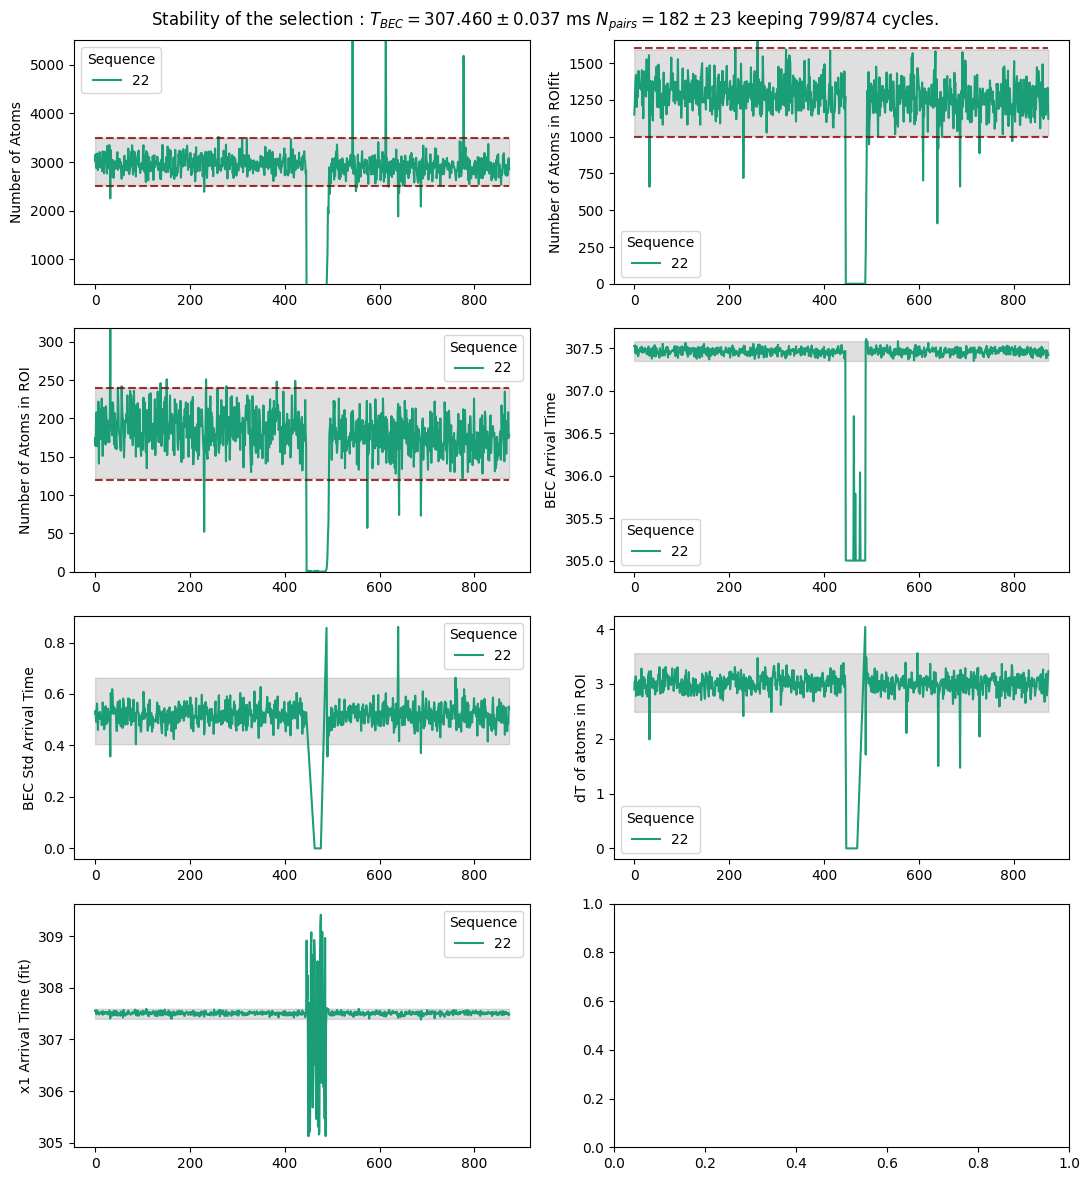

In [6]:
FILTERS = {"Number of Atoms":[2500,3500],"Number of Atoms in ROIfit":[1000,1600],
          "Number of Atoms in ROI": [120, 240 ]}
# Filtre des cycles
selected_data, selec_bec_arrival_times = data_filter(atoms, bec_arrival_times,FILTERS )

############# PLOTS ##############
columns_to_plot=["Number of Atoms",
        "Number of Atoms in ROIfit",
        "Number of Atoms in ROI",
        "BEC Arrival Time",
        "BEC Std Arrival Time","dT of atoms in ROI",  "x1 Arrival Time (fit)"
    ]
#"BEC Center X","BEC Center Y","BEC Std Arrival Time",  "BEC fitted Std Arrival Time"]

from heliumtools.misc.some_plots_volume1 import stability_of_sequence
stability_of_sequence(bec_arrival_times,
    columns_to_plot=columns_to_plot,
    filters=FILTERS)


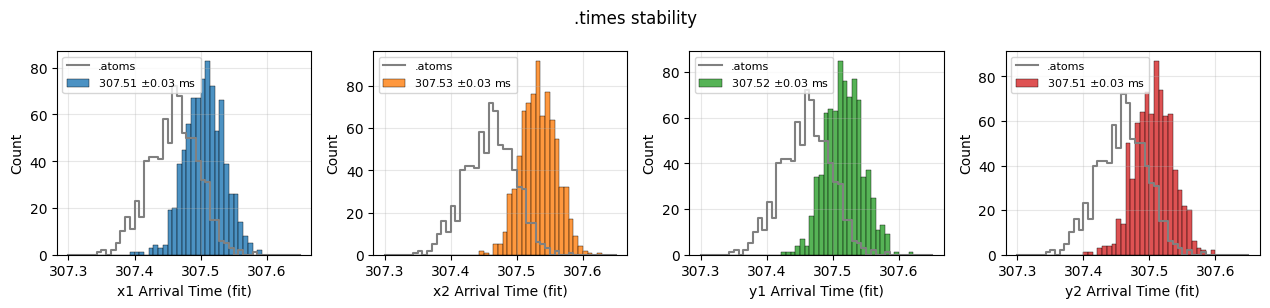

In [7]:
ncols = 4
nrows = 1
df = selec_bec_arrival_times
fig, axes = plt.subplots(figsize = (3.2 * ncols, 3.1 * nrows) , ncols = ncols, nrows = nrows)
for i, val in enumerate(["x1", "x2", "y1", "y2"]):
    to_plot = val + " Arrival Time (fit)"
    ax = axes.flatten()[i]

    sns.histplot(data = df, x = to_plot, color = f"C{i}", alpha = 0.8,
             label = "{:.2f} $\pm ${:.2f} ms".format(np.mean(df[to_plot]),
                                                  np.std(df[to_plot])),
             bins = np.linspace(307.3, 307.65, 50), ax = ax)
    sns.histplot(data=df, x="BEC Arrival Time", element="step", fill=False,color = "gray",
                 bins = np.linspace(307.3, 307.65, 50), ax = ax, label = ".atoms")
    ax.legend(fontsize = 8)
    ax.grid(True, alpha = 0.3)
    #ax.set_yscale('log')
fig.suptitle(".times stability")
plt.tight_layout()
plt.show()

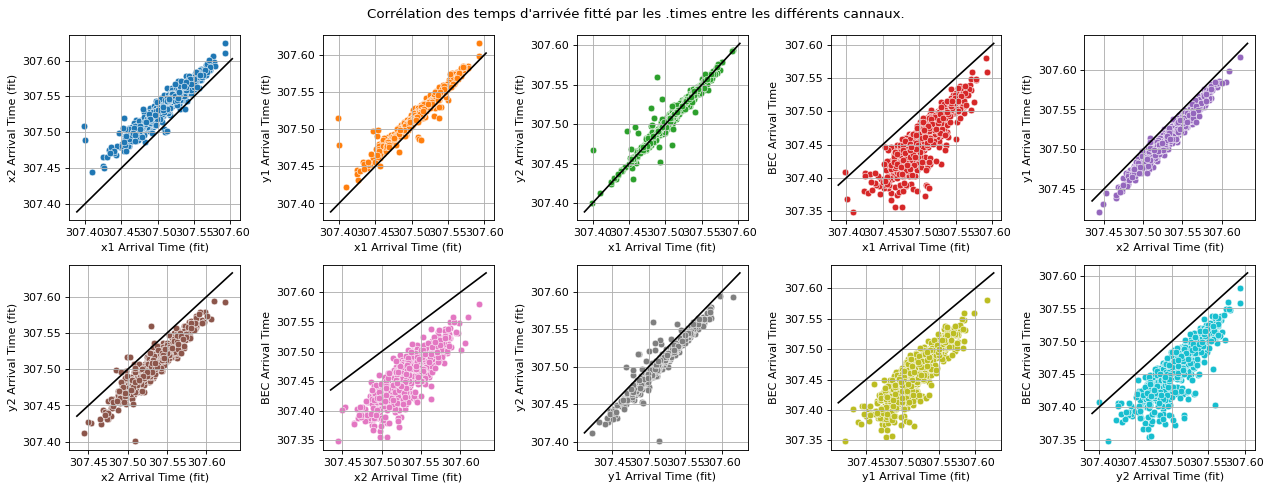

In [8]:
import itertools
couples = list(itertools.combinations(["x1 Arrival Time (fit)", "x2 Arrival Time (fit)",
                                       "y1 Arrival Time (fit)", "y2 Arrival Time (fit)",
                                      "BEC Arrival Time"], 2))
ncols = 5
nrows = ceil(len(couples)/ncols)
fig, axes = plt.subplots(figsize = (3.2 * ncols, 3.1 * nrows) , ncols = ncols, nrows = nrows, dpi = 80)
for i , key in enumerate(couples):
    ax = axes.flatten()[i]
    sns.scatterplot(data = selec_bec_arrival_times, 
                    x = key[0] , 
                    y = key[1] , 
                    ax = ax,color = f"C{i}"
                   )
    mini, maxi = ax.get_xlim()
    ax.plot(np.linspace(mini, maxi, 12),np.linspace(mini, maxi, 12), color = "Black")
    ax.grid(True)
fig.suptitle("Corrélation des temps d'arrivée fitté par les .times entre les différents cannaux.", )
plt.tight_layout()
#plt.savefig("Correlation_arrival_time_between_channels_reconstruits.png")

# Densité des paires
Dans la suite du notebook, on mettra en majuscule les variables qui n'ont pas de vocation à être changées.

 

In [18]:
ecart_temps_arrive = 0.25
moyenne_temps_arrive = 307.5

REF_FRAME_SPEED = {"Vx": -3.1, "Vy": -3.2, "Vz": 94 }
REF_FRAME_SPEED = {"Vx": 0, "Vy": 0, "Vz": 93 }
ARRIVAL_TIME = 307.55450877426836
ARRIVAL_TIME = 307.53

BOXZSIZE = 1
XYsize = 25
DEFAULT_BOXES  = {
    "1": {
        "Vx": {"size": XYsize, "position": 0},
        "Vy": {"size": XYsize, "position": 0},
        "Vz": {"size": BOXZSIZE, "position": 25},
    },
    "2": {
        "Vx": {"size": XYsize, "position": 0},
        "Vy": {"size": XYsize, "position": 0},
        "Vz": {"size": BOXZSIZE, "position": -25},
    },
}



<Figure size 640x480 with 0 Axes>

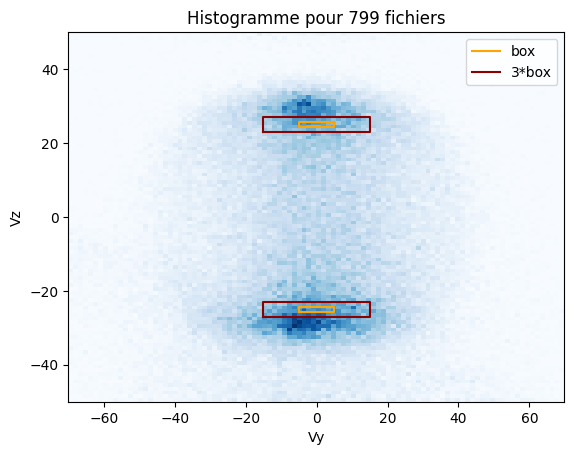

<Figure size 640x480 with 0 Axes>

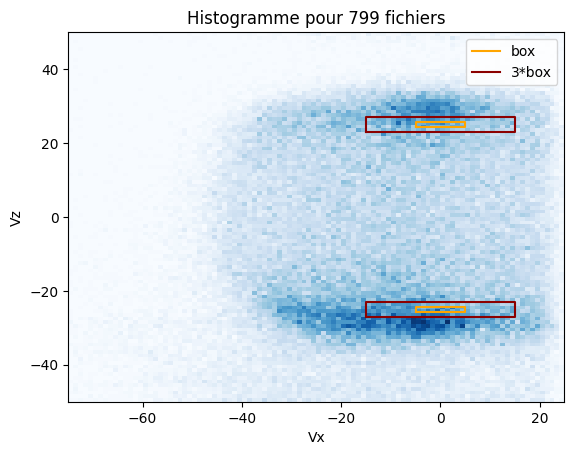

<Figure size 640x480 with 0 Axes>

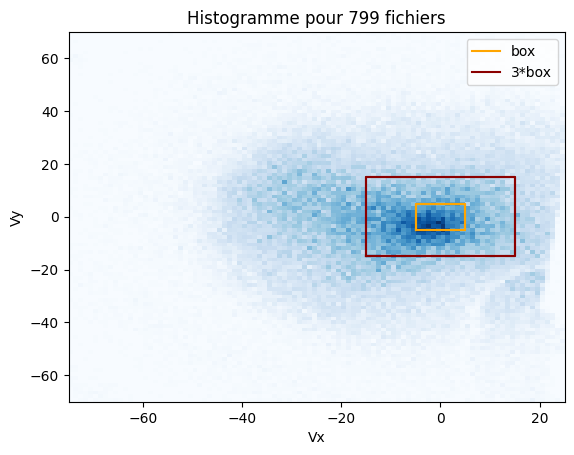

In [25]:

### Instanciations de la classe corrélation

boxZsize = 1.3
boxXYsize = 10
Xposition = 0
Yposition = 0
peak1 = [-35, -22]
peak2 = [22, 37]
boxes = {
    "1": {
        "Vx": {"size": boxXYsize, "position": Xposition},
        "Vy": {"size": boxXYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": 25},
    },
    "2": {
        "Vx": {"size": boxXYsize, "position": Xposition},
        "Vy": {"size": boxXYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": -25},
    },
}
ROI = {
    "Vz": {"min": -50, "max": 50},
    "Vy": {"min": -70, "max": 70},
    "Vx": {"max": 25, "min": -75},
}
boite = copy.deepcopy(boxes)

corr = Correlation(
    selected_data,
    ROI=ROI,
    boxes=boxes,
    bec_arrival_time=ARRIVAL_TIME,
   ref_frame_speed =REF_FRAME_SPEED,
)

hist = corr.show_density(nameX="Vy", nameY="Vz", show_plot=True)
hist = corr.show_density(nameX="Vx", nameY="Vz", show_plot=True)
hist = corr.show_density(nameX="Vx", nameY="Vy", show_plot=True)



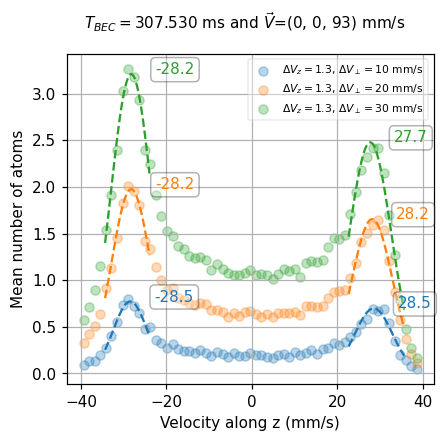

In [26]:

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * standard_deviation ** 2))
#### Figure du nombre moyen d'atomes par boite : 
total_df = []
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz", min=-40, max=40, step=boxZsize
)
fig, ax = plt.subplots(figsize = (4.3, 3.9), dpi = 110)
for i, vperp_max in enumerate([10, 20, 30]):
    my_box = {"Vperp": {"minimum" : -1, "maximum" : vperp_max}}
    atoms = corr.get_atoms_in_box(corr.atoms, my_box)
    hist, bins = np.histogram(atoms["Vz"],bins = np.arange(-40, 40,boxZsize))
    x = (bins[0:-1] + bins[1:])/2
    plt.scatter( x,  hist / corr.n_cycles, alpha = .3,
             label = r"$\Delta V_z={:.1f}, \, \Delta V_\perp={:.0f}$ mm/s ".format(boxZsize, vperp_max))
    
    ###### Fits de la paire 1
    try:
        hist1, bins1 = np.histogram(atoms["Vz"],bins = np.arange(peak1[0],peak1[1], boxZsize))
        hist1 =hist1/corr.n_cycles
        bin_centers1 = np.array(bins1[:-1] + np.diff(bins1) / 2)
        max_index =np.argmax(hist1)
        p0 = [bin_centers1[max_index], np.max(hist1), np.mean(hist1*(bin_centers1-bin_centers1[max_index]))]
        popt, pcov_paire_1 = curve_fit(gaussian, bin_centers1, hist1, p0=p0)
        fit_absc = np.linspace(np.min(bin_centers1),np.max(bin_centers1),50)
        plt.plot(fit_absc, gaussian(fit_absc, *popt),"--", color = "C"+str(i)) 
        ax.text(0.8*popt[0],popt[1],"{:.1f}".format(popt[0]), color =  "C"+str(i), 
                ha = 'left', bbox = dict(facecolor = 'white', alpha = 0.3, boxstyle="round"))
    except:
        print('failed to fit pair 1')
    
    ###### Fits de la paire 2
    try:
        hist1, bins1 = np.histogram(atoms["Vz"],bins = np.arange(peak2[0],peak2[1], boxZsize))
        hist1 =hist1/corr.n_cycles
        bin_centers1 = np.array(bins1[:-1] + np.diff(bins1) / 2)
        max_index =np.argmax(hist1)
        #p0 = mean, amplitude, standard_deviation

        p0 = [bin_centers1[max_index], np.max(hist1), np.mean(hist1*(bin_centers1-bin_centers1[max_index])**2)]
        popt, pcov_paire_1 = curve_fit(gaussian, bin_centers1, hist1, p0=p0,maxfev = 5000)
        fit_absc = np.linspace(np.min(bin_centers1),np.max(bin_centers1),50)
        plt.plot(fit_absc, gaussian(fit_absc, *popt),"--", color = "C"+str(i)) 
        ax.text(1.2*popt[0],popt[1],"{:.1f}".format(popt[0]), color =  "C"+str(i), 
                ha = 'left', bbox = dict(facecolor = 'white', alpha = 0.3, boxstyle="round"))
    except:
        print('failed to fit pair 2')

fig.suptitle(r"$T_{{BEC}} = {:.3f}$ ms and $\vec{{V}}$=({}, {}, {}) mm/s".format(
     corr.bec_arrival_time,corr.ref_frame_speed["Vx"], corr.ref_frame_speed["Vy"], corr.ref_frame_speed["Vz"]),
            fontsize = 'medium')
            
plt.ylabel("Mean number of atoms")
plt.grid(True)
plt.xlabel("Velocity along z (mm/s)")
plt.legend(framealpha = 0.4, fontsize="7",)
#plt.savefig("densite_selon_z.png")
plt.show()

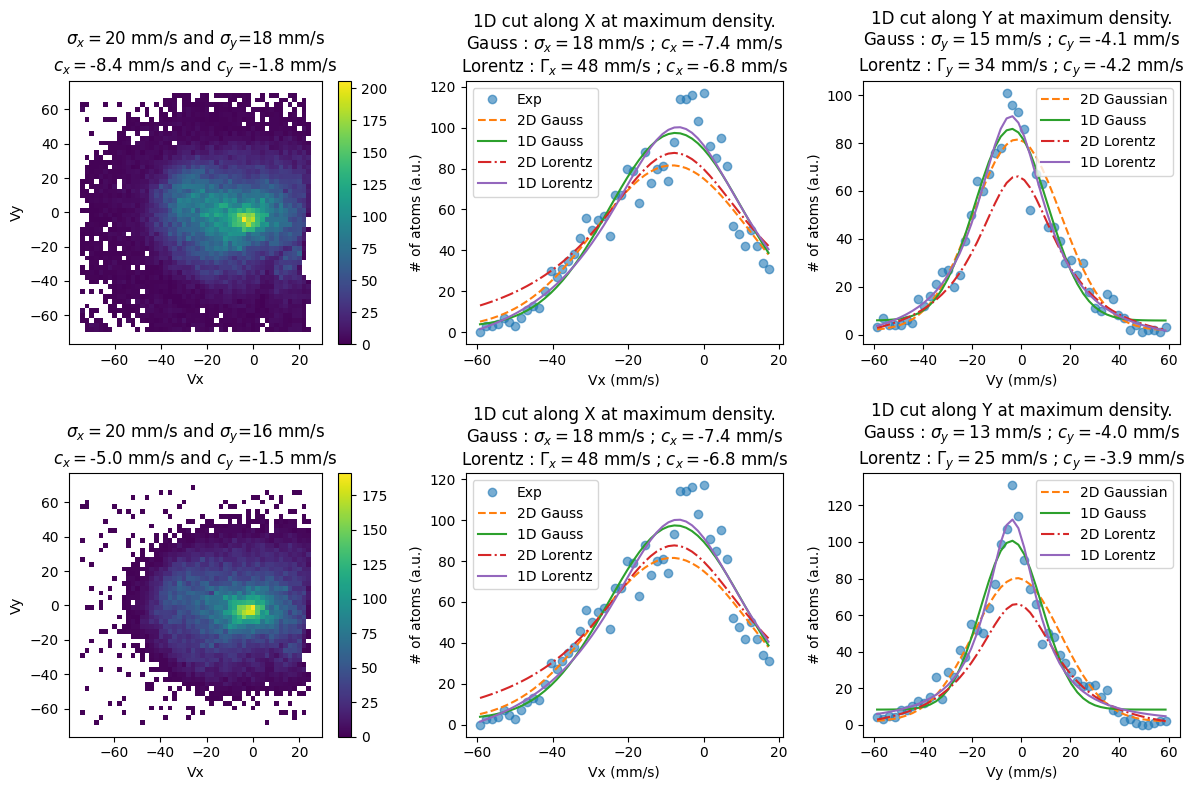

In [24]:
peak1 = corr.atoms[(corr.atoms["Vz"] < - 10) & (corr.atoms["Vz"] > - 40)]
peak2 = corr.atoms[(corr.atoms["Vz"] <  40) & (corr.atoms["Vz"] > 10)]
from heliumtools.fit.gauss2D import Gauss2DFit, Gauss2D
from heliumtools.fit.gauss1D import Gauss1DFit
from heliumtools.fit.lorentz2D import Lorentz2DFit
from heliumtools.fit.lorentz1D import Lorentz1DFit

n_bins = 50

fig, axes = plt.subplots(figsize = (12, 8), ncols = 3, nrows = 2)
# Première colonne : densité
ax = axes[0, 0]
sns.histplot(data=peak1, x = 'Vx', y = 'Vy', ax = axes[0,0],cmap="viridis",cbar = True, bins = (n_bins, n_bins))
hist_data, vx_data, vy_data = np.histogram2d(peak1["Vx"], peak1["Vy"], bins=n_bins, range=([-60, 18], [-60, 60]))
vy_data = ( vy_data[0:-1] + vy_data[1:])/2
vx_data = (vx_data[0:-1] + vx_data[1:])/2
VY, VX = np.meshgrid(vy_data, vx_data)
g2Dfit = Gauss2DFit(x=(VX, VY), z=hist_data)
g2Dfit.do_guess()
g2Dfit.do_fit()
fit_data = g2Dfit.eval(x=(VX, VY))
l2Dfit = Lorentz2DFit(x=(VX, VY), z=hist_data)
l2Dfit.do_guess()
l2Dfit.do_fit()
fit_data_lorentz = l2Dfit.eval(x=(VX, VY))
popt1 = g2Dfit.popt
axes[0,0].set_title(r"$\sigma_x=${:.0f} mm/s and $\sigma_y$={:.0f} mm/s".format(g2Dfit.popt[2], g2Dfit.popt[3] )
                    + "\n"
                    + "$c_x = ${:.1f} mm/s and $c_y$ ={:.1f} mm/s".format( g2Dfit.popt[4], g2Dfit.popt[5] ))
## Coupe 1D Selon X, Y est fixé au maximum de densité. On refait un fit mais 1D. 
minimumVY = np.argmin(np.abs(vy_data - g2Dfit.popt[5] ))
ax = axes[0,1]
g1Dfit = Gauss1DFit(x=vx_data, z=hist_data[:,minimumVY])
g1Dfit.do_guess()
g1Dfit.do_fit()
l1Dfit = Lorentz1DFit(x=vx_data, z=hist_data[:,minimumVY])
l1Dfit.do_guess()
l1Dfit.do_fit()
ax.plot(vx_data, hist_data[:,minimumVY], "o", alpha = 0.6, label = "Exp")
ax.plot(vx_data, fit_data[:,minimumVY], "--", alpha = 1, label = "2D Gauss")
ax.plot(vx_data, g1Dfit.eval(x= vx_data), "-", alpha =1, label = "1D Gauss")
ax.plot(vx_data, fit_data_lorentz[:,minimumVY], "-.", alpha =1, label = "2D Lorentz")
ax.plot(vx_data, l1Dfit.eval(x= vx_data), "-", alpha = 1, label = "1D Lorentz")
ax.set_ylabel("# of atoms (a.u.)")
ax.set_xlabel("Vx (mm/s)")
ax.legend()
ax.set_title("1D cut along X at maximum density."+ "\n"
            +"Gauss : $\sigma_x=${:.0f} mm/s ; $c_x = ${:.1f} mm/s".format( g1Dfit.popt[2], g1Dfit.popt[3] )
             + "\n"
            +"Lorentz : $\Gamma_x=${:.0f} mm/s ; $c_x = ${:.1f} mm/s".format( l1Dfit.popt[2], l1Dfit.popt[3] ))
## Coupe 1D Selon Y, X est fixé au maximum de densité. On refait un fit mais 1D. 
minimumVX = np.argmin(np.abs(vx_data - g2Dfit.popt[4] ))
ax = axes[0,2]
g1Dfit = Gauss1DFit(x=vy_data, z=hist_data[minimumVX,:])
g1Dfit.do_guess()
g1Dfit.do_fit()
l1Dfit = Lorentz1DFit(x=vy_data, z=hist_data[minimumVX,:])
l1Dfit.do_guess()
l1Dfit.do_fit()
ax.set_title("1D cut along Y at maximum density")
ax.plot(vy_data, hist_data[minimumVX,:], "o", alpha = 0.6)
ax.plot(vy_data, fit_data[minimumVX,:], "--", alpha = 1, label = "2D Gaussian")
ax.plot(vy_data, g1Dfit.eval(x= vy_data), "-", alpha =1, label = "1D Gauss")
ax.plot(vy_data, fit_data_lorentz[minimumVY,:], "-.", alpha = 1, label = "2D Lorentz")
ax.plot(vy_data, l1Dfit.eval(x= vy_data), "-", alpha = 1, label = "1D Lorentz")
ax.set_ylabel("# of atoms (a.u.)")
ax.set_xlabel("Vy (mm/s)")
ax.legend()
ax.set_title("1D cut along Y at maximum density."+ "\n"
            +"Gauss : $\sigma_y=${:.0f} mm/s ; $c_y = ${:.1f} mm/s".format( g1Dfit.popt[2], g1Dfit.popt[3] )
             + "\n"
            +"Lorentz : $\Gamma_y=${:.0f} mm/s ; $c_y = ${:.1f} mm/s".format( l1Dfit.popt[2], l1Dfit.popt[3] ))


sns.histplot(data=peak2, x = 'Vx', y = 'Vy', ax = axes[1,0], cmap="viridis", cbar = True, bins = (n_bins, n_bins))
hist_data1, vx_data1, vy_data1 = np.histogram2d(peak2["Vx"], peak2["Vy"], bins=n_bins, range=([-60, 18], [-60, 60]))
VY, VX = np.meshgrid(( vy_data1[0:-1] + vy_data1[1:])/2, (vx_data1[0:-1] + vx_data1[1:])/2)
g2Dfit = Gauss2DFit(x=(VX, VY), z=hist_data1)
g2Dfit.do_guess()
g2Dfit.do_fit()
popt2 = g2Dfit.popt
axes[1,0].set_title(r"$\sigma_x=${:.0f} mm/s and $\sigma_y$={:.0f} mm/s".format(g2Dfit.popt[2], g2Dfit.popt[3])
                    + "\n"
                    + "$c_x = ${:.1f} mm/s and $c_y$ ={:.1f} mm/s".format( g2Dfit.popt[4], g2Dfit.popt[5] ))
## Coupe 1D Selon X, Y est fixé au maximum de densité. On refait un fit mais 1D. 
minimumVY = np.argmin(np.abs(vy_data - g2Dfit.popt[5] ))
ax = axes[1,1]
g1Dfit = Gauss1DFit(x=vx_data, z=hist_data[:,minimumVY])
g1Dfit.do_guess()
g1Dfit.do_fit()
l1Dfit = Lorentz1DFit(x=vx_data, z=hist_data[:,minimumVY])
l1Dfit.do_guess()
l1Dfit.do_fit()
ax.plot(vx_data, hist_data[:,minimumVY], "o", alpha = 0.6, label = "Exp")
ax.plot(vx_data, fit_data[:,minimumVY], "--", alpha = 1, label = "2D Gauss")
ax.plot(vx_data, g1Dfit.eval(x= vx_data), "-", alpha =1, label = "1D Gauss")
ax.plot(vx_data, fit_data_lorentz[:,minimumVY], "-.", alpha =1, label = "2D Lorentz")
ax.plot(vx_data, l1Dfit.eval(x= vx_data), "-", alpha = 1, label = "1D Lorentz")
ax.set_ylabel("# of atoms (a.u.)")
ax.set_xlabel("Vx (mm/s)")
ax.legend()
ax.set_title("1D cut along X at maximum density."+ "\n"
            +"Gauss : $\sigma_x=${:.0f} mm/s ; $c_x = ${:.1f} mm/s".format( g1Dfit.popt[2], g1Dfit.popt[3] )
             + "\n"
            +"Lorentz : $\Gamma_x=${:.0f} mm/s ; $c_x = ${:.1f} mm/s".format( l1Dfit.popt[2], l1Dfit.popt[3] ))
## Coupe 1D Selon Y, X est fixé au maximum de densité. On refait un fit mais 1D. 
minimumVX = np.argmin(np.abs(vx_data - g2Dfit.popt[4] ))
ax = axes[1,2]
g1Dfit = Gauss1DFit(x=vy_data, z=hist_data[minimumVX,:])
g1Dfit.do_guess()
g1Dfit.do_fit()
l1Dfit = Lorentz1DFit(x=vy_data, z=hist_data[minimumVX,:])
l1Dfit.do_guess()
l1Dfit.do_fit()
ax.set_title("1D cut along Y at maximum density")
ax.plot(vy_data, hist_data[minimumVX,:], "o", alpha = 0.6)
ax.plot(vy_data, fit_data[minimumVX,:], "--", alpha = 1, label = "2D Gaussian")
ax.plot(vy_data, g1Dfit.eval(x= vy_data), "-", alpha =1, label = "1D Gauss")
ax.plot(vy_data, fit_data_lorentz[minimumVY,:], "-.", alpha = 1, label = "2D Lorentz")
ax.plot(vy_data, l1Dfit.eval(x= vy_data), "-", alpha = 1, label = "1D Lorentz")
ax.set_ylabel("# of atoms (a.u.)")
ax.set_xlabel("Vy (mm/s)")
ax.legend()
ax.set_title("1D cut along Y at maximum density."+ "\n"
            +"Gauss : $\sigma_y=${:.0f} mm/s ; $c_y = ${:.1f} mm/s".format( g1Dfit.popt[2], g1Dfit.popt[3] )
             + "\n"
            +"Lorentz : $\Gamma_y=${:.0f} mm/s ; $c_y = ${:.1f} mm/s".format( l1Dfit.popt[2], l1Dfit.popt[3] ))

plt.tight_layout()
plt.show()



# Corrélations

## Corrélation en Vz

In [30]:
corr.result.columns

Index(['Vz1', 'Vz2', 'Cycle', 'N_1', 'N_2', 'N_1*N_2', 'N_1**2', 'N_2**2',
       'N_1-N_2', '(N_1-N_2)^2', 'N_1+N_2', '(N_1-N_2)^4', 'M^2 jasukula',
       'M jaskula', 'variance', 'normalized variance', 'g^2', 'C-S',
       'C-S difference', 'G^2(k1,k1)', 'G^2(k2,k2)', 'g^2(k1,k1)',
       'g^2(k2,k2)', 'var(M jaskula)', 'N_1 std', 'N_2 std', 'N_1 rel',
       'N_2 rel', 'N_1*N_2 std', 'N_1-N_2 std', '(N_1-N_2)^2 std',
       'N_1+N_2 std', 'variance std', 'N_1 error', 'N_2 error',
       'N_1*N_2 error', 'N_1-N_2 error', '(N_1-N_2)^2 error', 'N_1+N_2 error',
       'variance error', 'normalized variance error', 'g^2 error',
       'normalized variance error2', 'N_1 (at/(mm/s)^3)', 'N_2 (at/(mm/s)^3)',
       'N_1 (at/(mm/s)^3) std', 'N_2 (at/(mm/s)^3) std',
       'N_1 (at/(mm/s)^3) error', 'N_2 (at/(mm/s)^3) error', '(Vz1+Vz2)/2',
       'Vz1+Vz2', '(Vz1-Vz2)/2', 'Vz1-Vz2', '(Vz2-Vz1)/2', 'Vz2-Vz1'],
      dtype='object')

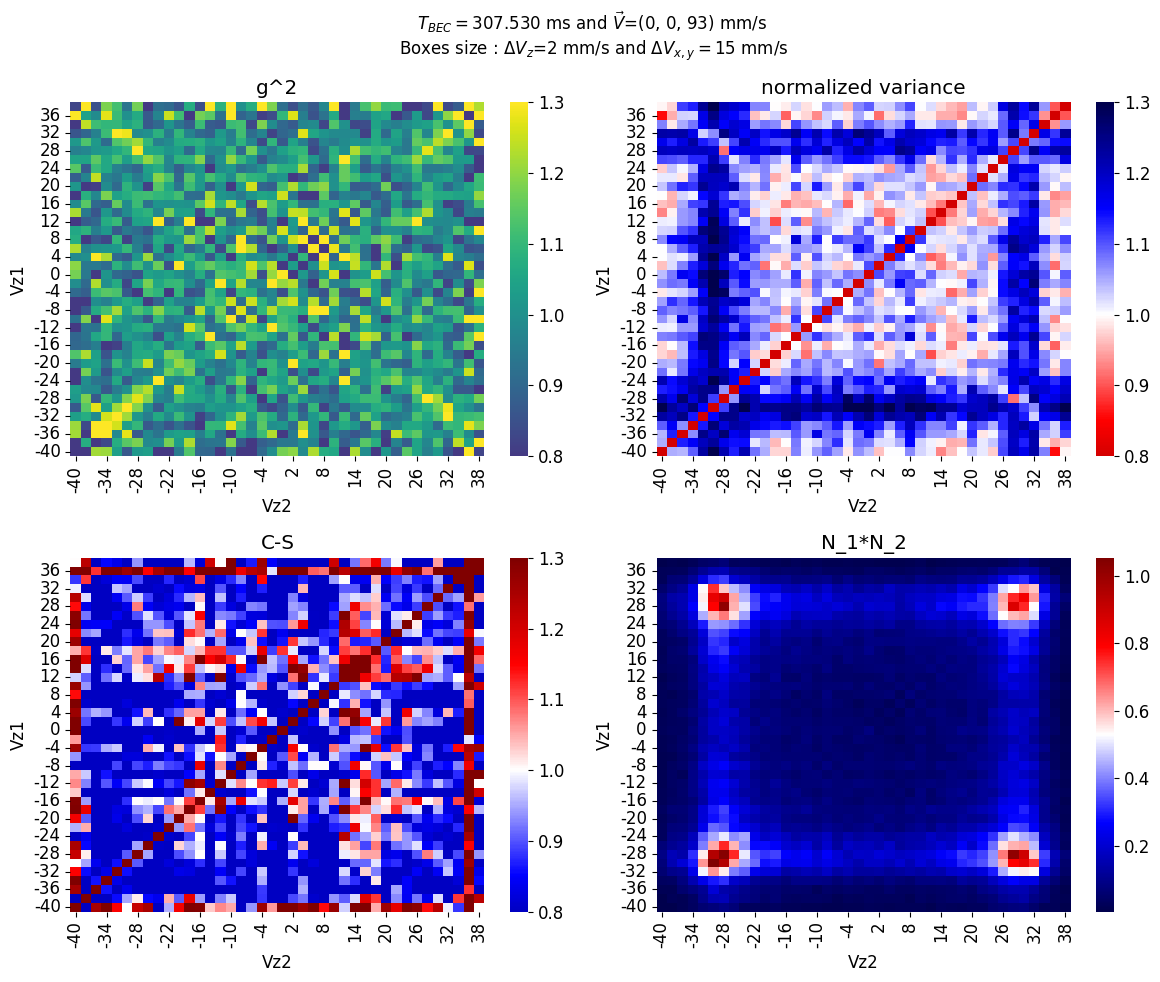

In [42]:
to_plot = ["g^2", "normalized variance", "C-S", "N_1*N_2"]
ROI = {
    "Vz": {"min": -50, "max": 50},
    "Vy": {"min": -70, "max": 70},
    "Vx": {"max": 25, "min": -75},
}
boxZsize = 2
boxXYsize = 15
Xposition = 0
Yposition = 0
boxes  = {
    "1": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": -25},
    },
    "2": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": +25},
    },
}
corr = Correlation(
    selected_data,
    ROI=ROI,
    boxes=boxes,
    raman_kick=42.5,
    bec_arrival_time=ARRIVAL_TIME,
   ref_frame_speed = REF_FRAME_SPEED,
)
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=-40, max=40, step=boxZsize
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=-40, max=40, step=boxZsize
)
corr.compute_correlations()

ncols =  2
nrows = ceil(len(to_plot)/ncols)
fig, axes = plt.subplots(figsize = (6*ncols,5*nrows), ncols = ncols, nrows = nrows, dpi=100)
axes = axes.flatten()
# g^2
ax = axes[0]
val = "g^2"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values="g^2"),
    cmap="viridis",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# VARIANCE
ax = axes[1]
val = "normalized variance"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic_r",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# Cauchy_Schwarz
ax = axes[2]
val = "C-S"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# G^2
ax = axes[3]
val = "N_1*N_2"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic",ax=ax,
)
ax.set_title(val)
ax.invert_yaxis()
title = r"$T_{{BEC}} = {:.3f}$ ms and $\vec{{V}}$=({}, {}, {}) mm/s".format(
     corr.bec_arrival_time,corr.ref_frame_speed["Vx"], corr.ref_frame_speed["Vy"], corr.ref_frame_speed["Vz"])
title += "\n "
title +="Boxes size : $\Delta V_z$={} mm/s and $\Delta V_{{x,y}}=${} mm/s ".format(boxZsize, boxXYsize)
fig.suptitle(title, fontsize = 'medium')
plt.tight_layout()

plt.show()

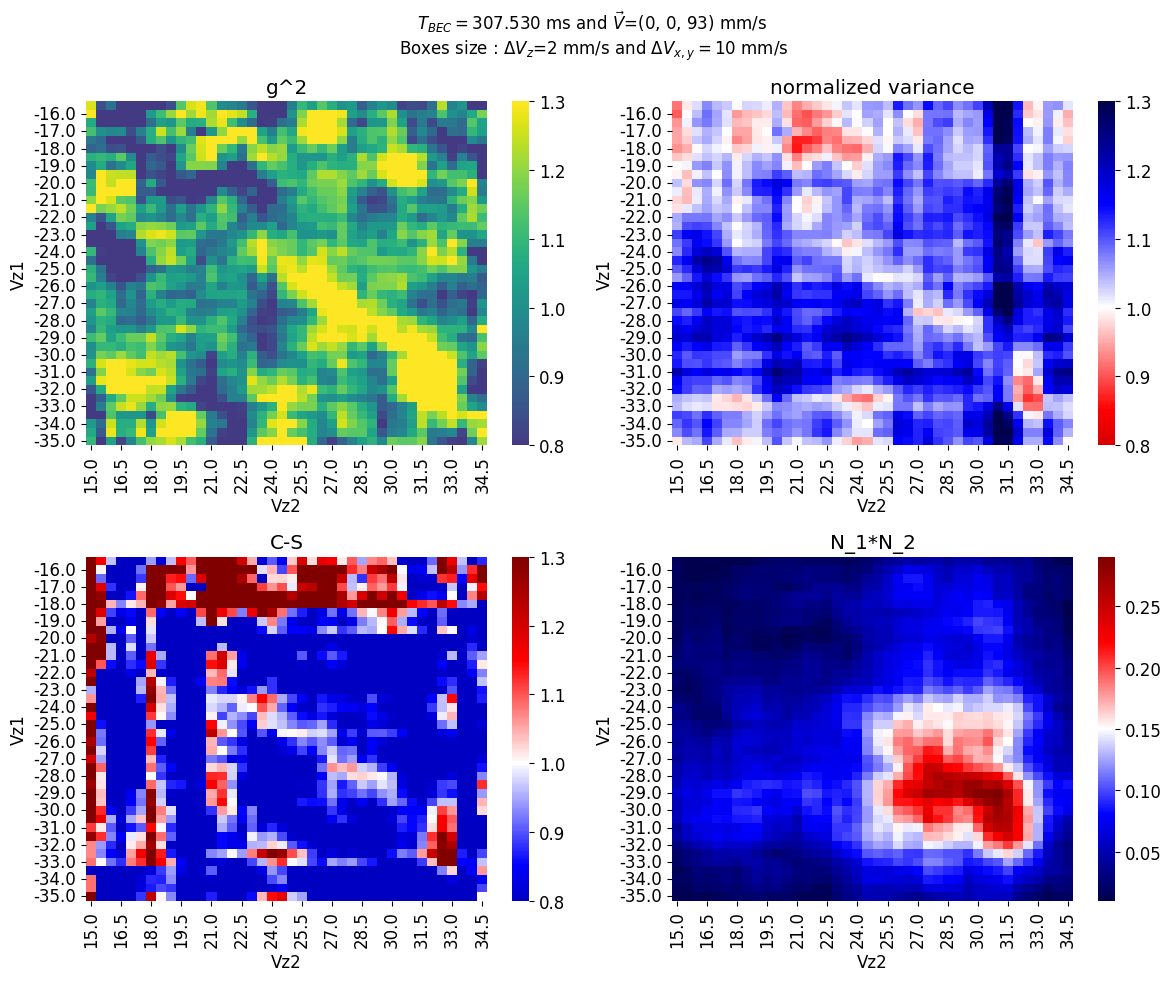

In [48]:
to_plot = ["g^2", "normalized variance", "C-S", "N_1*N_2"]
ROI = {
    "Vz": {"min": -50, "max": 50},
    "Vy": {"min": -70, "max": 70},
    "Vx": {"max": 25, "min": -75},
}
boxZsize = 2
boxXYsize = 10
Xposition = 0
Yposition = 0
boxes  = {
    "1": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": -25},
    },
    "2": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": +25},
    },
}
corr = Correlation(
    selected_data,
    ROI=ROI,
    boxes=boxes,
    raman_kick=42.5,
    bec_arrival_time=ARRIVAL_TIME,
   ref_frame_speed = REF_FRAME_SPEED,
)
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=-35, max=-15, step=0.5
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=15, max=35, step=0.5
)
corr.compute_correlations()

ncols =  2
nrows = ceil(len(to_plot)/ncols)
fig, axes = plt.subplots(figsize = (6*ncols,5*nrows), ncols = ncols, nrows = nrows, dpi=100)
axes = axes.flatten()
# g^2
ax = axes[0]
val = "g^2"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values="g^2"),
    cmap="viridis",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# VARIANCE
ax = axes[1]
val = "normalized variance"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic_r",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# Cauchy_Schwarz
ax = axes[2]
val = "C-S"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic",ax=ax, vmin = 0.8, vmax = 1.3, center = 1
)
ax.set_title(val)
ax.invert_yaxis()
# G^2
ax = axes[3]
val = "N_1*N_2"
sns.heatmap(
    corr.result.pivot(index="Vz1", columns="Vz2", values=val),
    cmap="seismic",ax=ax,
)
ax.set_title(val)
ax.invert_yaxis()
title = r"$T_{{BEC}} = {:.3f}$ ms and $\vec{{V}}$=({}, {}, {}) mm/s".format(
     corr.bec_arrival_time,corr.ref_frame_speed["Vx"], corr.ref_frame_speed["Vy"], corr.ref_frame_speed["Vz"])
title += "\n "
title +="Boxes size : $\Delta V_z$={} mm/s and $\Delta V_{{x,y}}=${} mm/s ".format(boxZsize, boxXYsize)
fig.suptitle(title, fontsize = 'medium')
plt.tight_layout()

plt.show()

## Corrélations en Vx et Vy


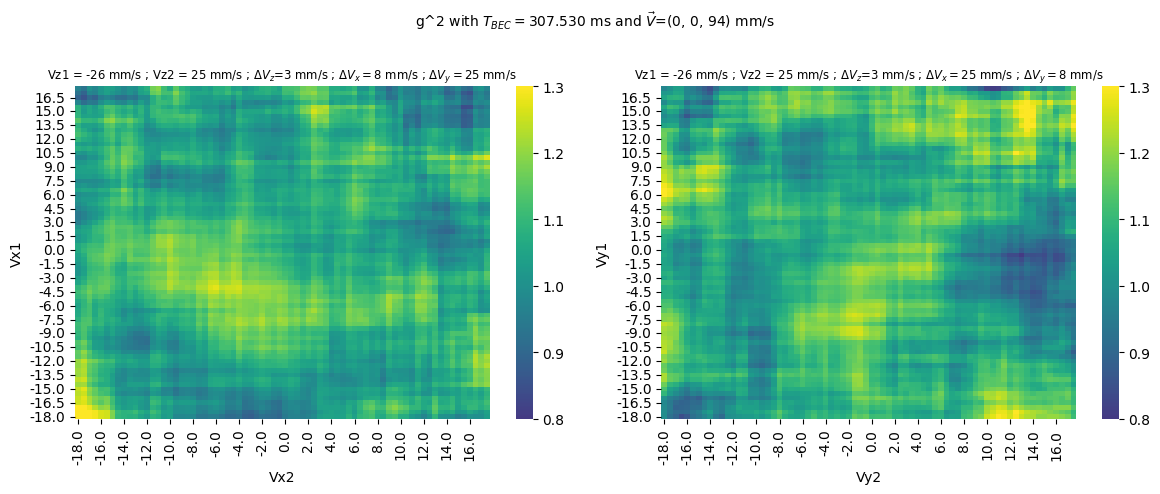

In [28]:
boxZsize = 3
boxXYsize = 25
small_sizeXY = 8
MAX_CMAP = 1.3
MIN_CMAP = 0.8
CMAP = "viridis"
Y_TO_PLOT = "g^2"#"normalized variance"
ROI = {
        "Vz": {"min": -50, "max": 50},
        "Vy": {"min": -70, "max": 70},
        "Vx": {"max": 25, "min": -75},
}

boxes  = {
    "1": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": -26},
    },
    "2": {
        "Vx": {"size": boxXYsize, "position": 0},
        "Vy": {"size": boxXYsize, "position": 0},
        "Vz": {"size": boxZsize, "position": +25},
    },
}
local_frame = {"Vx": -3.1, "Vy": -3.2, "Vz": 94 }
local_frame = {"Vx": -0, "Vy": -0, "Vz": 94 }



###### Plots XY
ncols =  2
nrows = 1
fig, axes = plt.subplots(figsize = (6*ncols,5*nrows), ncols = ncols, nrows = nrows, dpi=100)
axes = axes.flatten()
for j, Vj in enumerate(["Vx", "Vy"]):
    ax = axes.flatten()[j]
    

    corr = Correlation(
        selected_data,
        ROI=ROI,
        boxes=boxes,
        raman_kick=42.5,
        bec_arrival_time=ARRIVAL_TIME,
       ref_frame_speed = local_frame,
        remove_shot_noise = False
    )
    corr.boxes["1"]["Vz"]["size"] = 2
    corr.boxes["1"]["Vz"]["size"] = 2
    corr.boxes["1"][Vj]["size"] = small_sizeXY
    corr.boxes["2"][Vj]["size"] = small_sizeXY
    corr.define_variable1(
        box="1", axe=Vj, type="position", name=Vj + "1", min=-18, max=18, step=0.5
    )
    corr.define_variable2(
        box="2", axe=Vj, type="position", name=Vj + "2", min=-18, max=18, step=0.5
    )
    corr.compute_correlations()
    
    
    sns.heatmap(
        corr.result.pivot(index=Vj + "1", columns=Vj + "2", values=Y_TO_PLOT),
        cmap=CMAP,center=1,ax=ax,vmax = MAX_CMAP,vmin =MIN_CMAP

        )
    
    ax.invert_yaxis()
    title = "Vz1 = {} mm/s ; Vz2 = {} mm/s ; $\Delta V_z$={} mm/s ; $\Delta V_x=${} mm/s ; $\Delta V_y=${} mm/s ".format(
    corr.boxes["1"]["Vz"]["position"], 
    corr.boxes["2"]["Vz"]["position"],
    corr.boxes["2"]["Vz"]["size"],
    corr.boxes["2"]["Vx"]["size"],
    corr.boxes["2"]["Vy"]["size"])
    ax.set_title(title, fontsize = "small")

title = Y_TO_PLOT + " with " + r"$T_{{BEC}} = {:.3f}$ ms and $\vec{{V}}$=({}, {}, {}) mm/s".format(
 corr.bec_arrival_time,corr.ref_frame_speed["Vx"], corr.ref_frame_speed["Vy"], corr.ref_frame_speed["Vz"])
title += "\n "

fig.suptitle(title, fontsize = 'medium')
plt.tight_layout()
plt.show()